# Health Impact Classification

#### Data Description

##### Record Information
RecordID: A unique identifier assigned to each record (1 to 2392).

##### Air Quality Metrics
AQI: Air Quality Index, a measure of how polluted the air currently is or how polluted it is forecast to become.<br>
PM10: Concentration of particulate matter less than 10 micrometers in diameter (μg/m³).<br>
PM2_5: Concentration of particulate matter less than 2.5 micrometers in diameter (μg/m³).<br>
NO2: Concentration of nitrogen dioxide (ppb).<br>
SO2: Concentration of sulfur dioxide (ppb).<br>
O3: Concentration of ozone (ppb).<br>

##### Weather Conditions
Temperature: Temperature in degrees Celsius (°C).<br>
Humidity: Humidity percentage (%).<br>
WindSpeed: Wind speed in meters per second (m/s).<br>

##### Health Impact Metrics
RespiratoryCases: Number of respiratory cases reported.<br>
CardiovascularCases: Number of cardiovascular cases reported.<br>
HospitalAdmissions: Number of hospital admissions reported.<br>

##### Target Variable: Health Impact Class
HealthImpactScore: A score indicating the overall health impact based on air quality and other related factors, ranging from 0 to 100.<br>
HealthImpactClass: Classification of the health impact based on the health impact score:<br>

0: 'Very High' (HealthImpactScore >= 80)<br>
1: 'High' (60 <= HealthImpactScore < 80)<br>
2: 'Moderate' (40 <= HealthImpactScore < 60)<br>
3: 'Low' (20 <= HealthImpactScore < 40)<br>
4: 'Very Low' (HealthImpactScore < 20)<br>

### Set-Up and Load Data

In [203]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

# Import CSV as df
df = pd.read_csv('data/air_quality_health_impact_data.csv')
print(df.head()) # Preview first 5 rows

   RecordID         AQI        PM10       PM2_5         NO2        SO2  \
0         1  187.270059  295.853039   13.038560    6.639263  66.161150   
1         2  475.357153  246.254703    9.984497   16.318326  90.499523   
2         3  365.996971   84.443191   23.111340   96.317811  17.875850   
3         4  299.329242   21.020609   14.273403   81.234403  48.323616   
4         5   78.009320   16.987667  152.111623  121.235461  90.866167   

           O3  Temperature   Humidity  WindSpeed  RespiratoryCases  \
0   54.624280     5.150335  84.424344   6.137755                 7   
1  169.621728     1.543378  46.851415   4.521422                10   
2    9.006794     1.169483  17.806977  11.157384                13   
3   93.161033    21.925276  99.473373  15.302500                 8   
4  241.795138     9.217517  24.906837  14.534733                 9   

   CardiovascularCases  HospitalAdmissions  HealthImpactScore  \
0                    5                   1          97.244041   
1   

In [204]:
# Dataset Size and Structure
df.shape  # 5811 rows, 15 columns

(5811, 15)

### Pre-Processing

In [205]:
# No missing values
df.isnull().sum()

RecordID               0
AQI                    0
PM10                   0
PM2_5                  0
NO2                    0
SO2                    0
O3                     0
Temperature            0
Humidity               0
WindSpeed              0
RespiratoryCases       0
CardiovascularCases    0
HospitalAdmissions     0
HealthImpactScore      0
HealthImpactClass      0
dtype: int64

In [206]:
# Remove identifier, redundant for prediction analysis
df = df.drop(columns=["RecordID"], errors="ignore")

### Exploratory Data Analysis (EDA)

#### Statistical Summary

In [207]:
# Datatypes and Missing Values
df.info() # Integer - int64(4) and Float - float64(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811 entries, 0 to 5810
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AQI                  5811 non-null   float64
 1   PM10                 5811 non-null   float64
 2   PM2_5                5811 non-null   float64
 3   NO2                  5811 non-null   float64
 4   SO2                  5811 non-null   float64
 5   O3                   5811 non-null   float64
 6   Temperature          5811 non-null   float64
 7   Humidity             5811 non-null   float64
 8   WindSpeed            5811 non-null   float64
 9   RespiratoryCases     5811 non-null   int64  
 10  CardiovascularCases  5811 non-null   int64  
 11  HospitalAdmissions   5811 non-null   int64  
 12  HealthImpactScore    5811 non-null   float64
 13  HealthImpactClass    5811 non-null   int64  
dtypes: float64(10), int64(4)
memory usage: 635.7 KB


In [208]:
df.describe().T # Count, mean, standard devation, minimum, maximum, and quartiles

,count,mean,std,min,25%,50%,75%,max
AQI,5811.0,248.438476,144.777638,0.005817,122.951293,249.127841,373.630668,499.858837
PM10,5811.0,148.654997,85.698500,0.015848,75.374954,147.634997,222.436759,299.901962
PM2_5,5811.0,100.223714,58.096612,0.031549,49.435171,100.506337,151.340260,199.984965
NO2,5811.0,102.293445,57.713175,0.009625,53.538538,102.987736,151.658516,199.980195
SO2,5811.0,49.456838,28.530329,0.011023,24.887264,49.530165,73.346617,99.969561
O3,5811.0,149.312431,86.534240,0.001661,73.999665,149.559871,223.380126,299.936812
Temperature,5811.0,14.975500,14.483067,-9.990998,2.481500,14.942428,27.465374,39.963434
Humidity,5811.0,54.776853,26.020786,10.001506,31.995262,54.543904,77.641639,99.997493
WindSpeed,5811.0,9.989177,5.776950,0.002094,4.952343,10.051742,14.971840,19.999139
RespiratoryCases,5811.0,9.974187,3.129234,1.000000,8.000000,10.000000,12.000000,23.000000


In [209]:
df.nunique() # Variety of values
'''
All measurements are continuous data
Very low cardinality in the classification variables
Moderate cardinality for the rest (Scoring and Count-based Metrics)
'''

'\nAll measurements are continuous data\nVery low cardinality in the classification variables\nModerate cardinality for the rest (Scoring and Count-based Metrics)\n'

#### Univariate Analysis

##### Numerical Values

In [224]:
# Histogram Mean
def hist_mean(data, **kwargs):
    sns.histplot(data['Value'], kde=True, **kwargs)
    plt.axvline(data['Value'].mean(), color='red', linestyle='dashed', linewidth=2) # Mean line
    
# Facet Grids
def facet_plots(df, plot_type, col_wrap):

    # Melt to long format - categorical column 'Feature' against 'Value'
    numeric_df = df.select_dtypes(include='number')  # Excl melted 'Value' cols
    df_long = numeric_df.melt(var_name='Feature', value_name='Value')
    
    # Create FacetGrid
    gr = sns.FacetGrid(df_long, col='Feature', col_wrap=col_wrap, sharex=False, sharey=False)
    # Plot Type
    if plot_type == 'hist': # Histogram
        gr.map_dataframe(hist_mean)
        for ax, feature in zip(gr.axes.flat, df_long['Feature'].unique()):
            skew_val = df_long[df_long['Feature'] == feature]['Value'].skew()
            ax.set_title(f"{feature} | Skew: {skew_val:.2f}")
    if plot_type == 'box': # Boxplot
        gr.map(sns.boxplot, 'Value')
        gr.set_titles("{col_name}")

    gr.figure.subplots_adjust(top=0.9)
    plt.show()

    # WHO recommended standards
    # PM2_5 15 μg/m³
    # PM10 45 μg/m³
    # NO2 25 μg/m³ 13.2 ppb
    # SO2 40 μg/m³ 15.3 ppb
    # O 15 μg/m³ 7.64 ppb


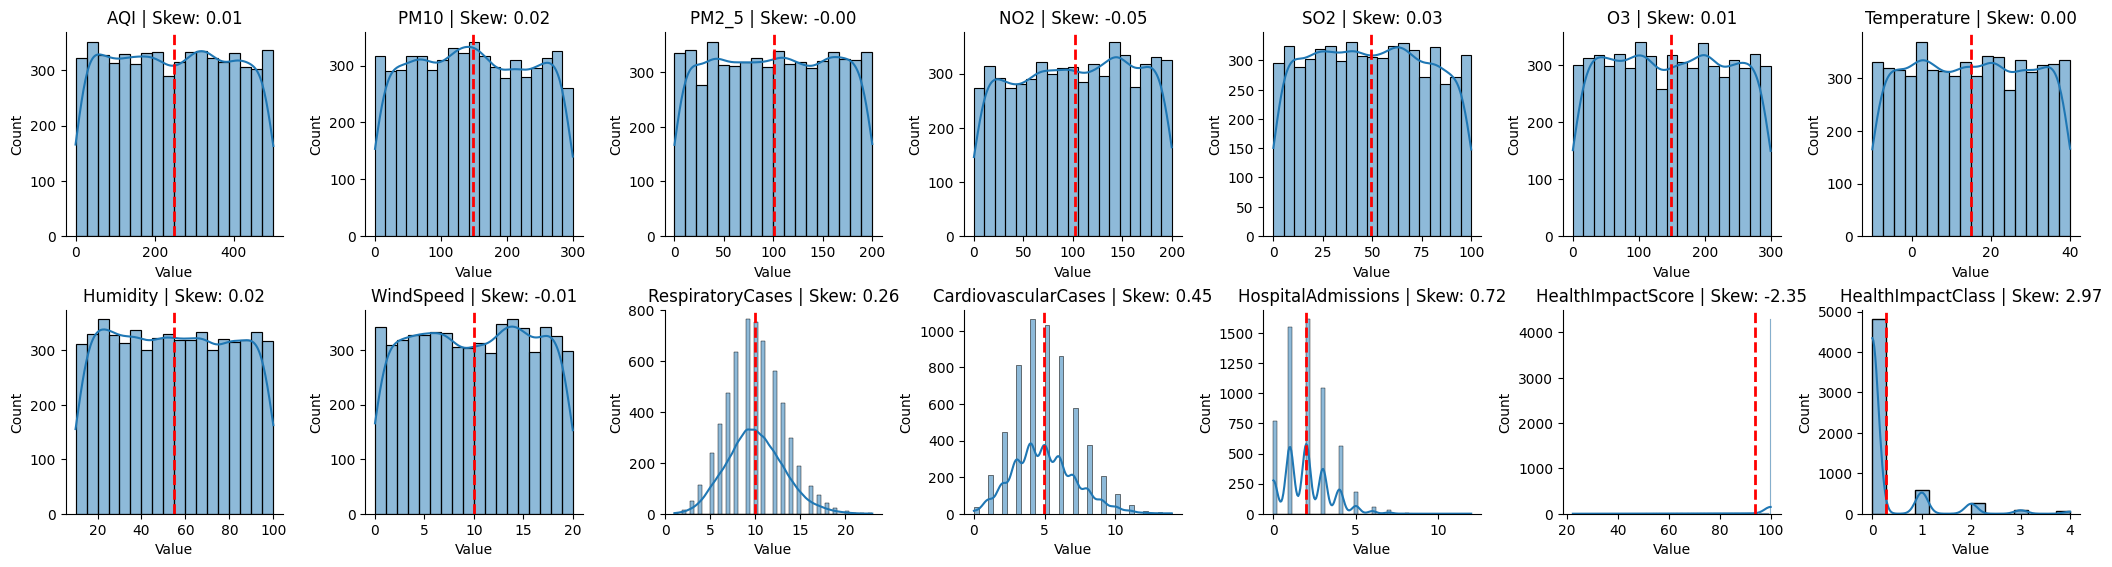

In [ ]:
# Histogram, Mean Line, Kernel Density - Distribution
facet_plots(df, 'hist', 7)

''' 
Objective: To identify distributions and variance across the features
Results: 
Even distributions - AQI, PM10, PM2_5, NO2, SO2, O3, Temperature, Humidity, Wind Speed
Respiratory and Cardiovascular Cases -  Weak positive skewed, indicates fewer low regions, central tendency
    - Higher concentration to lower value (fewer high instances)
Hospital Admissions - Positive skew, lower admissions with tapering tail towards high values
Health Impact Metrics - Skewed positively (high impact, more regions with significantly elevated scores)
Cases, Admissions, Health Impact Metrics have highest variance which may be due to diverse environmental conditions
'''

c:\Users\evakt\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


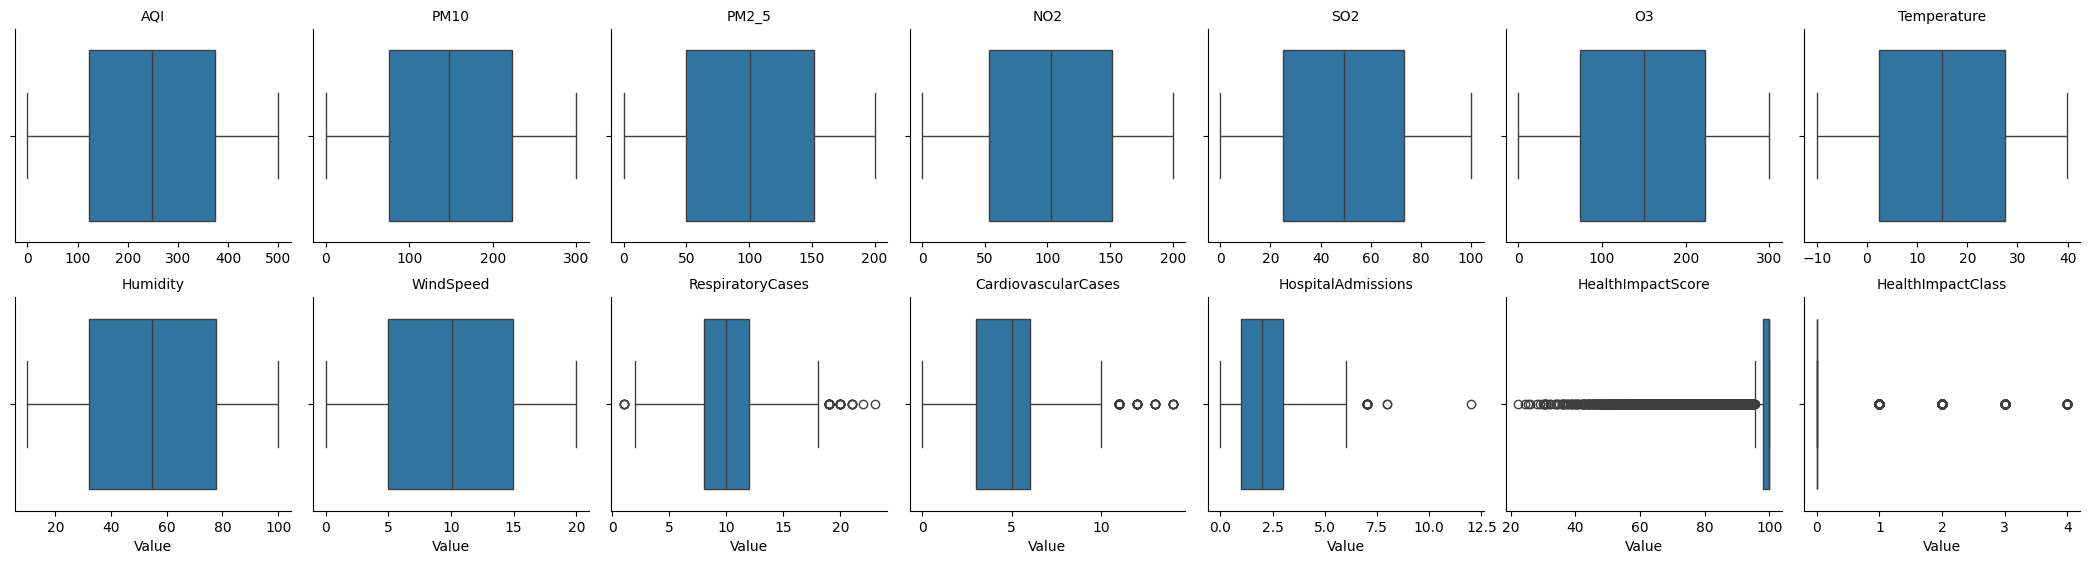

count    5811.000000
mean       93.785223
std        13.318904
min        22.448488
25%        98.203057
50%       100.000000
75%       100.000000
max       100.000000
Name: HealthImpactScore, dtype: float64

In [226]:
# Boxplots
facet_plots(df, 'box', 7)

''' 
Objective: To identify outliers and variance
Results: Outliers only in the most distributed features: 
         Respiratory and Cardiovascular Diseases, Hospital Admissions, and Health Impact Metrics
         Suggests skewed distributions 
         i.e. Health Impact Score has a positive skew
         Clustered extreme values concentrated, whilst all other lower values are evenly spread and varied
         May suggest class imbalances
'''
df['HealthImpactScore'].describe()

##### Categorial Values

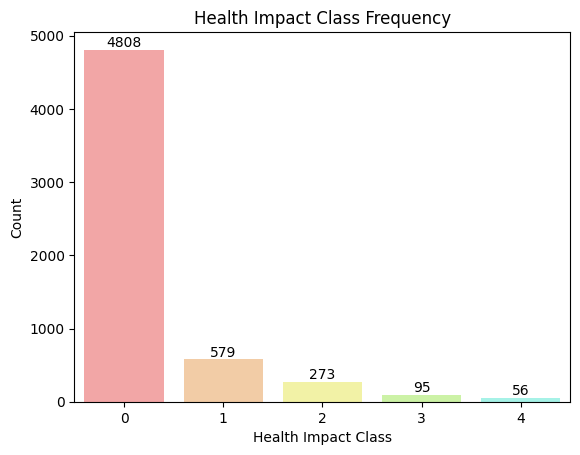

' \nObjective: To identify the variance of health impact class categories\nResults: Data is heavily skewed towards health impact of "Very High", Health Impact Score >= 80\n'

In [227]:
# Health Impact Class
# Bar Chart Palette
custom_colors = ["#FF9999", '#FFCC99', '#FFFF99', '#CCFF99', "#99FFF0"]
# Plot counts
ax = sns.countplot(x='HealthImpactClass', hue='HealthImpactClass', data=df, palette=custom_colors, legend=False)
# Title
plt.title('Health Impact Class Frequency')
# Add count labels 
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')
ax.set(xlabel='Health Impact Class', ylabel='Count')
plt.show()
#print(df['HealthImpactClass'].value_counts())

''' 
Objective: To identify the variance of health impact class categories
Results: Data is heavily skewed towards health impact of "Very High", Health Impact Score >= 80
'''

####  Multivariate Analysis

##### Correlation HeatMap

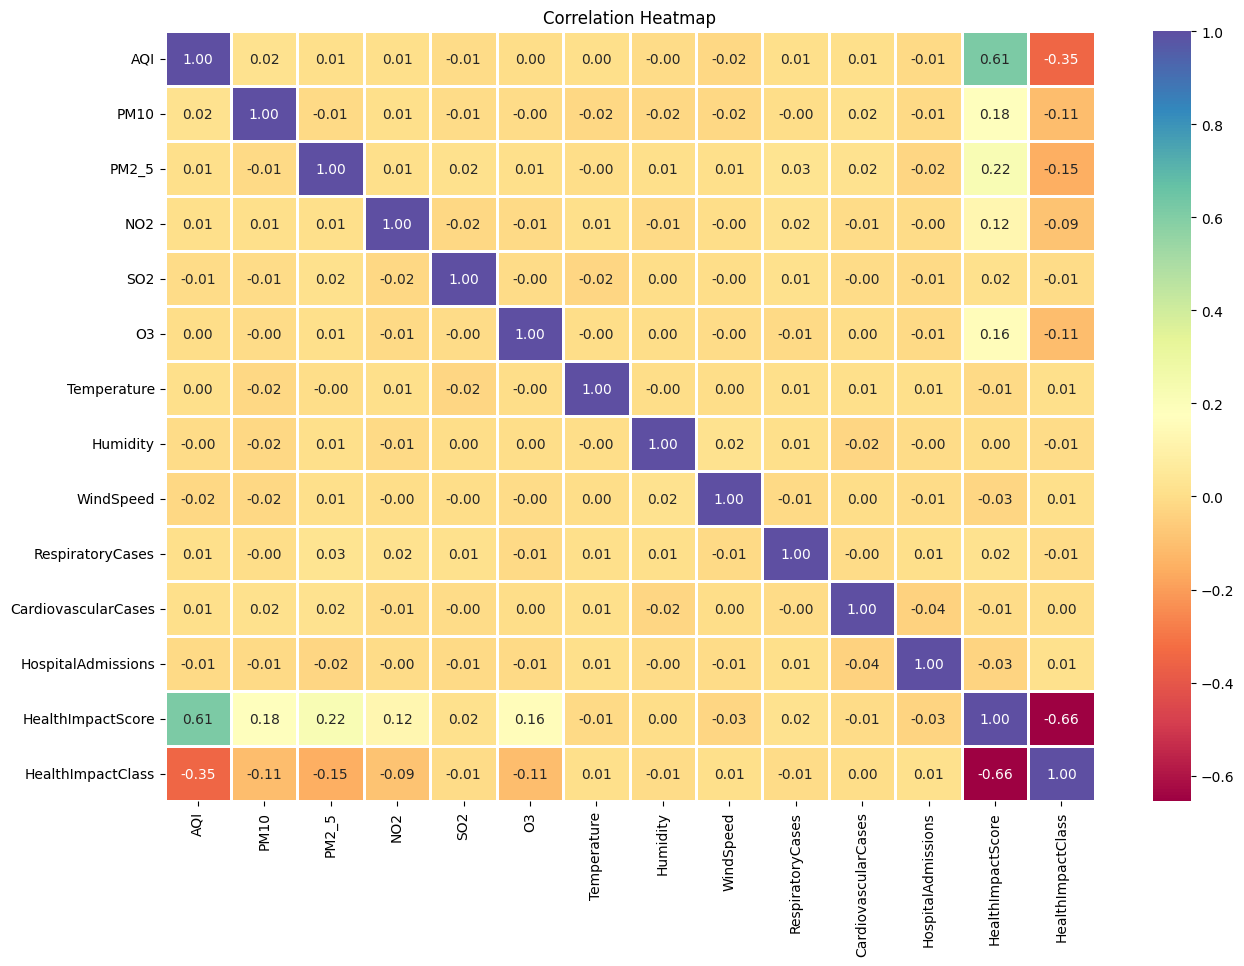

' \nObjective: To identify the pollutants with highest correlation to health impacts.\nResults: \nStronger positive correlations:\n    - AQI to Health Impact Score \n    - PM2_5, PM10, NO2, O3, S02 respectively to Health Impact Score\nMost critical pollutants: PM2_5 and PM10 \n'

In [215]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Spectral', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()
''' 
Objective: To identify the pollutants with highest correlation to health impacts.
Results: 
Stronger positive correlations:
    - AQI to Health Impact Score 
    - PM2_5, PM10, NO2, O3, S02 respectively to Health Impact Score
Most critical pollutants: PM2_5 and PM10 
'''

##### Pollutants vs Cases and Hospital Admission Rates

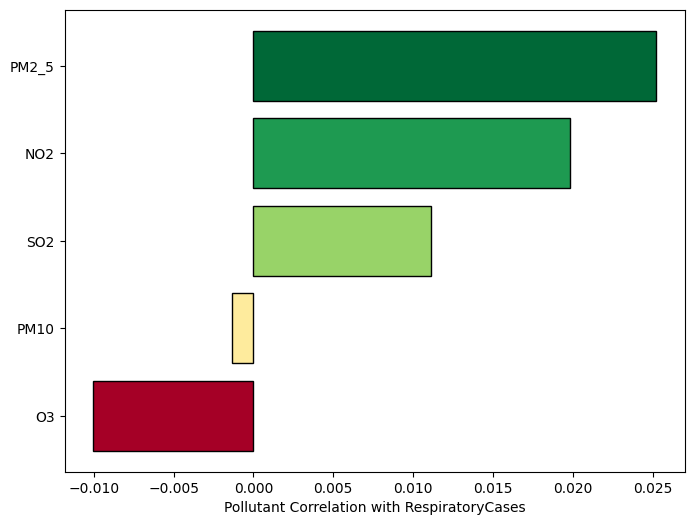

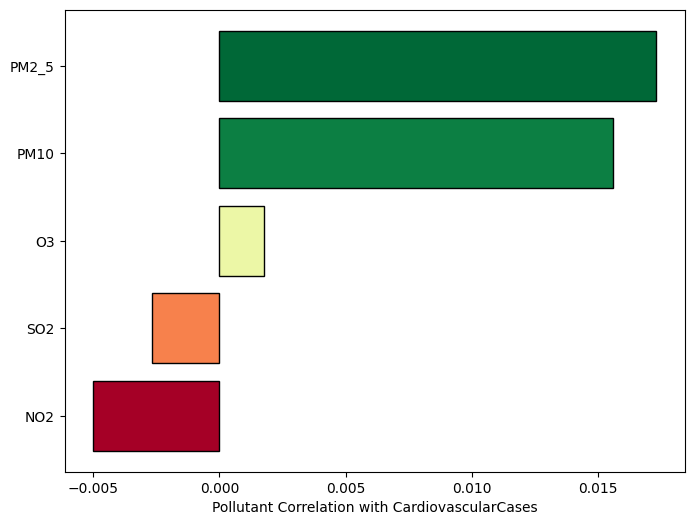

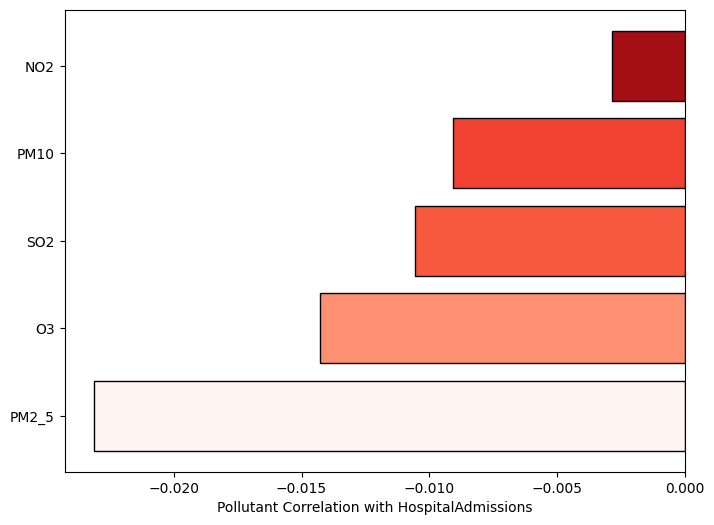

' \nObjective: To identify the pollutants with highest correlation to the seperate impacts (i.e. respiratory cases).\nResults: \nPositive correlations:\n    - PM2_5, NO2, SO2 respectively to Respiratory Cases \n        - Consistent with the ability of PM2_5 to penetrate deep into the lungs\n        - Consistent with the ability of NO2 and SO2 in exacerbating conditions such as asthma.\n    - PM2_5, PM10 respectively to Cardiovascular Cases\n        - Consistent with impact due to particulates penetrating to lungs and bloodstream\nNegative Correlations\n    - PM10, O3 have negative correlations to Respiratory Cases\n        - This may reflect when ozone levels are highest during summer, there are less respiratory cases\n    - SO2, NO2 have negative correlations to Cardiovascular Cases \n        - Suggests that they are less significant contributors to cardiovascular cases, but could be due to other correlating factors\n    - All pollutants have a negative correlation to hospital admissi

In [216]:
# Pollutants list
pollutants = ["PM10","PM2_5", "NO2", "SO2", "O3"]

# Pollutant Correlation
def polutant_correlations(feature):

    correlations = (df[pollutants].corrwith(df[feature])).sort_values() # Calculate correlation
    fig, ax = plt.subplots(figsize=(8, 6)) # Barplot
    bars = ax.barh(correlations.index, correlations.values, edgecolor='black')
    
    # Bar Colours vbased on Correlation
    vmin, vmax = correlations.min(), correlations.max()
    if vmin < 0 and vmax > 0:
        # Mixed: Red and Green
        divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = plt.cm.RdYlGn
    elif vmax <= 0:
        # All negative: Red
        divnorm = mpl.colors.Normalize(vmin=vmin, vmax=0)
        cmap = plt.cm.Reds
    else:
        # All positive: Green
        divnorm = mpl.colors.Normalize(vmin=0, vmax=vmax)
        cmap = plt.cm.Greens
    
    # Apply colour to each bar
    div_colors = cmap(divnorm(correlations.values))
    for bar, color in zip(bars, div_colors):
        bar.set_facecolor(color)

    # Add labels and layout
    ax.set_xlabel(f"Pollutant Correlation with {feature}")
    plt.show()
polutant_correlations("RespiratoryCases")
polutant_correlations("CardiovascularCases")
polutant_correlations("HospitalAdmissions")
# correlations = df[pollutants].corrwith(df['RespiratoryCases'])
# correlations.plot(kind='bar', title='Correlation with Respiratory Cases')

''' 
Objective: To identify the pollutants with highest correlation to the seperate impacts (i.e. respiratory cases).
Results: 
Positive correlations:
    - PM2_5, NO2, SO2 respectively to Respiratory Cases 
        - Consistent with the ability of PM2_5 to penetrate deep into the lungs
        - Consistent with the ability of NO2 and SO2 in exacerbating conditions such as asthma.
    - PM2_5, PM10 respectively to Cardiovascular Cases
        - Consistent with impact due to particulates penetrating to lungs and bloodstream
Negative Correlations
    - PM10, O3 have negative correlations to Respiratory Cases
        - This may reflect when ozone levels are highest during summer, there are less respiratory cases
    - SO2, NO2 have negative correlations to Cardiovascular Cases 
        - Suggests that they are less significant contributors to cardiovascular cases, but could be due to other correlating factors
    - All pollutants have a negative correlation to hospital admissions 
        - The negative correlations could be due to seasonal factors
        - i.e. lower pollution levels during times when hospital admissions are naturally higher (flu season, seasonal peaks summer - O3, winter - PM2_5, PM10, NO2, SO2).
Most critical pollutants: PM2_5 and PM10 
'''

### Training and Testing the Model

Random Forest Cross-Validation Accuracy Scores: [0.89853826 0.89931153 0.90963855 0.90963855 0.9070568 ] 
Random Forest Mean CV Accuracy: 0.9048 ± 0.0049
Random Forest Accuracy Score: 0.9217540842648323 

Random Forest Classification Report               precision    recall  f1-score   support

           0       0.95      0.99      0.97       982
           1       0.75      0.72      0.73       105
           2       0.70      0.53      0.61        43
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00         8

    accuracy                           0.92      1163
   macro avg       0.48      0.45      0.46      1163
weighted avg       0.89      0.92      0.91      1163



c:\Users\evakt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\evakt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\evakt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

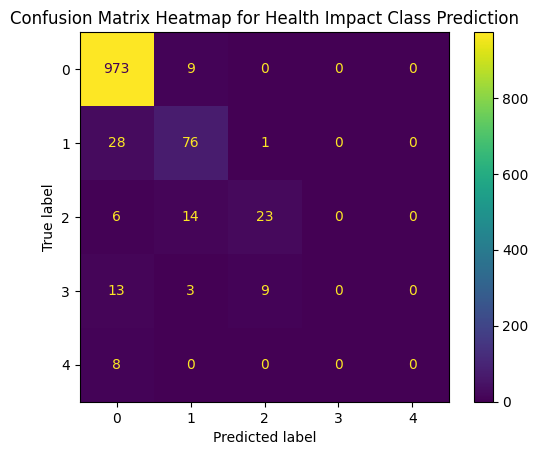

XGBoost Cross-Validation Accuracy Scores: [0.9011178  0.90275387 0.91394148 0.91480207 0.9130809 ] 
XGBoost Mean CV Accuracy: 0.9091 ± 0.0059
XGBoost Accuracy Score: 0.9251934651762683 

XGBoost Classification Report               precision    recall  f1-score   support

           0       0.96      0.98      0.97       982
           1       0.75      0.79      0.77       105
           2       0.68      0.58      0.62        43
           3       0.67      0.08      0.14        25
           4       0.00      0.00      0.00         8

    accuracy                           0.93      1163
   macro avg       0.61      0.49      0.50      1163
weighted avg       0.91      0.93      0.91      1163



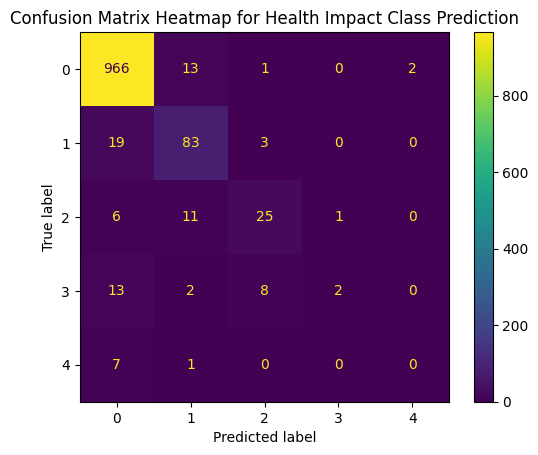

'\nSupervised Learning has dataset has known labeled data - HealthImpactClass \nHigher Accuracy and Known Clear Prediction Goal ("Very Low" to "Very High" predictions)\nXGBoost performs slightly higher\n'

In [217]:
# Data Prep
X = df.drop(columns=["HealthImpactScore", "HealthImpactClass", "RespiratoryCases", "CardiovascularCases", "HospitalAdmissions"])
y = df["HealthImpactClass"]

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Train models RF and XGBoost
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=30),
    "XGBoost": XGBClassifier(eval_metric='logloss',  random_state=30)
}

# Confusion Matrix Heatmap 
def confusionMatrix(model):
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis', values_format='d')  # 'd' for integer counts
    plt.title("Confusion Matrix Heatmap for Health Impact Class Prediction")
    plt.show()

for name, model, in models.items():
    # Cross-Validation - check performance on unseen data 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy Scores: {cv_scores}", f"\n{name} Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Prediction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Check Accuracy 
    print(f"{name} Accuracy Score:", accuracy_score(y_test, y_pred), "\n")
    print(f"{name} Classification Report", classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap 
    confusionMatrix(model)

'''
Supervised Learning has dataset has known labeled data - HealthImpactClass 
Higher Accuracy and Known Clear Prediction Goal ("Very Low" to "Very High" predictions)
XGBoost performs slightly higher
'''

### Performance Evaluation


 XGBoost Model Final Evaluation


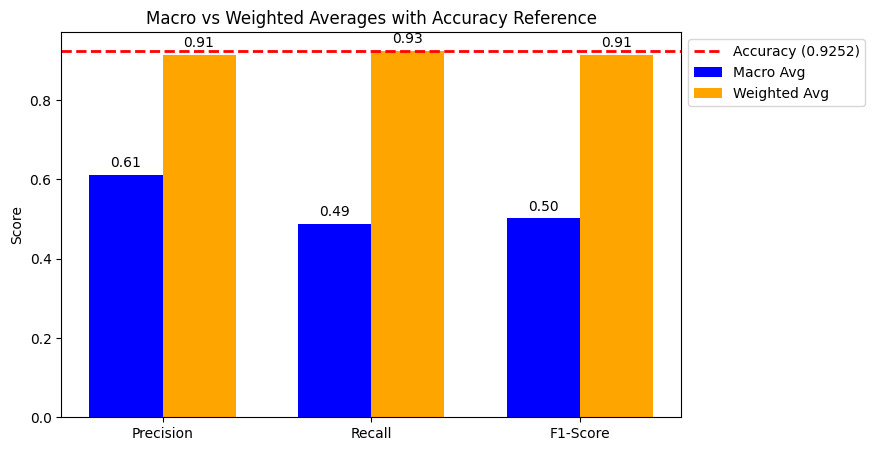

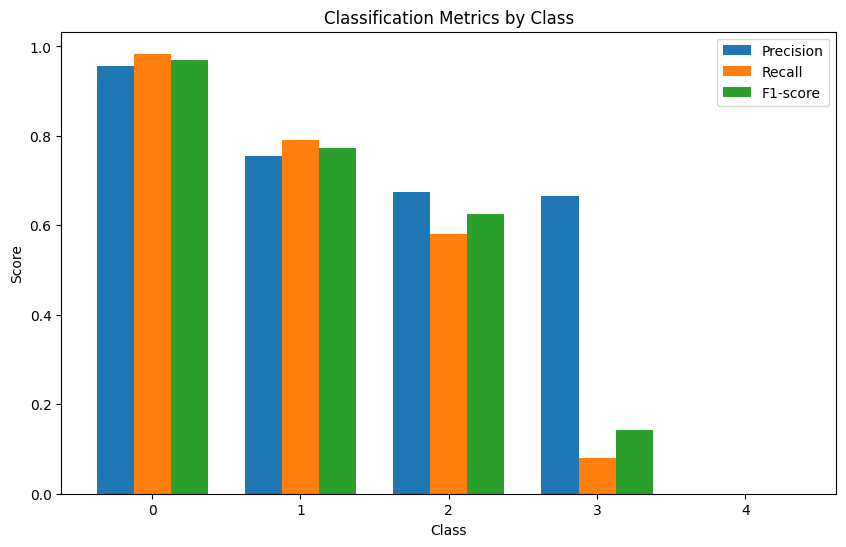

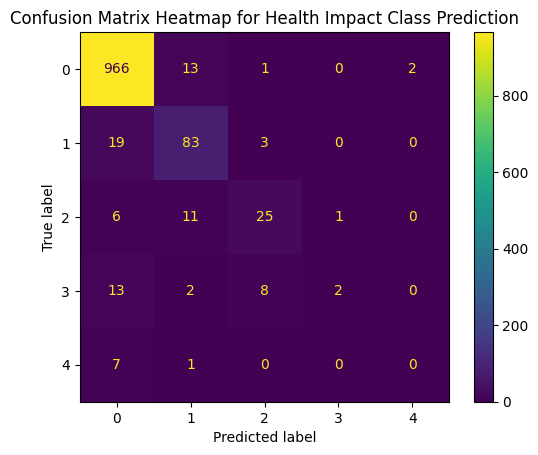

XGBoost Model saved as health_impact_classifier.pkl


In [218]:
# Evaluation
print(f"\n {name} Model Final Evaluation")

# Classification Report
report =  classification_report(y_test, y_pred, output_dict=True) # As dict
# print(f"Macro Average | Precision: {report['macro avg']['precision']:.2f}, Recall: {report['macro avg']['recall']:.2f}, F1-score: {report['macro avg']['f1-score']:.2f}")
# print(f"Weighted Average | Precision: {report['weighted avg']['precision']:.2f}, Recall: {report['weighted avg']['recall']:.2f}, F1-score: {report['weighted avg']['f1-score']:.2f}")
macro, weighted, accuracy = report['macro avg'], report['weighted avg'], report['accuracy'] # Extract macro and weighted averages
metrics = ['precision', 'recall', 'f1-score'] # Metrics to plot
macro_avg = [macro[m] for m in metrics]
weighted_avg = [weighted[m] for m in metrics]
# Bar chart setup
x = range(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([i - width/2 for i in x], macro_avg, width, label='Macro Avg', color='blue')
ax.bar([i + width/2 for i in x], weighted_avg, width, label='Weighted Avg', color='orange')
# Accuracy ref line
ax.axhline(y=accuracy, color='red', linestyle='--', linewidth=2, label=f'Accuracy ({accuracy:.4f})')
# Titles
ax.set_xticks(x)
ax.set_xticklabels([m.title() for m in metrics])
ax.set_ylabel('Score')
ax.set_title('Macro vs Weighted Averages with Accuracy Reference')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Value labels on top
for i in x:
    ax.text(i - width/2, macro_avg[i] + 0.02, f"{macro_avg[i]:.2f}", ha='center')
    ax.text(i + width/2, weighted_avg[i] + 0.02, f"{weighted_avg[i]:.2f}", ha='center')
plt.show()

# Scores
scores = [score for score, metrics in report.items() if isinstance(metrics, dict) and score not in [ 'accuracy', 'macro avg', 'weighted avg']]
# Prepare data for plotting
x = np.arange(len(scores))  # the label locations
# Extract metric values
precision_vals = [report[score]['precision'] for score in scores]
recall_vals = [report[score]['recall'] for score in scores]
f1_vals = [report[score]['f1-score'] for score in scores]
# Plot and Bars
fig, ax = plt.subplots(figsize=(10, 6)) 
width = 0.25  # Bar width
ax.bar(x - width, precision_vals, width, label='Precision')
ax.bar(x, recall_vals, width, label='Recall')
ax.bar(x + width, f1_vals, width, label='F1-score')
# Labels 
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(scores)
ax.legend()
plt.show()

# Confusion Matrix Heatmap 
confusionMatrix(model)

# Save model for later use
joblib.dump(model, "health_impact_classifier.pkl")
print(f"{name} Model saved as health_impact_classifier.pkl")

#### Feature Importance

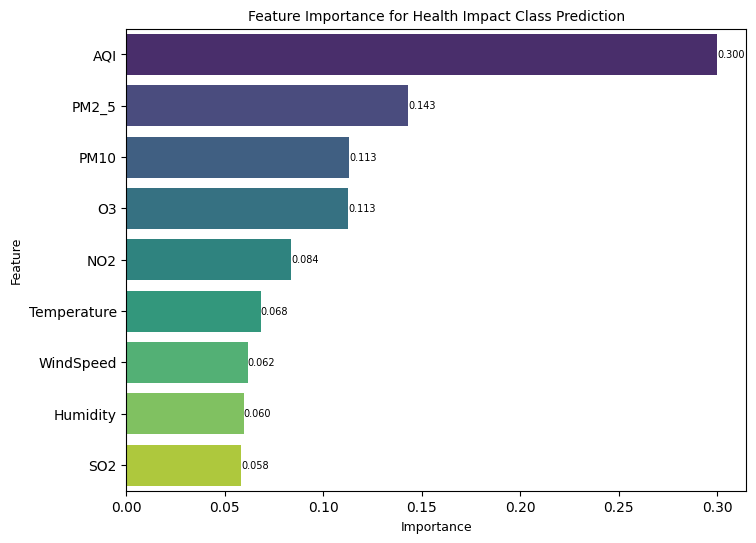

'\nAQI\t\n    - 0.360\n    - Key Predictor, most likely as it includes the other features\nPM2_5, O3, PM10, NO2, SO2\n    - 0.053 to 0.108\n    - Meaningful Impact\nTemperature, Humidity, WindSpeed\n    - 0.52 to 0.054\n    - Somewhat meaningful\nRespiratoryCases, CardiovascularCases, HospitalAdmissions\t\n    - 0.023–0.035\n    - Less meaningful\nRemoved HealthImpactScore as it will dominate the model\nRemoved less relevant RespiratoryCases, CardiovascularCases, HospitalAdmissions\t\n'

In [219]:
# Feature Importance 
feature_importances = model.feature_importances_
features = X.columns
# Sort features by importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue=features, palette='viridis', dodge=False, legend=False)
# Add value labels
for i, (imp, feat) in enumerate(zip(importance_df['Importance'], importance_df['Feature'])):
    plt.text(imp, i, f'{imp:.3f}', va='center', fontsize=7)
plt.title('Feature Importance for Health Impact Class Prediction', fontsize=10)
plt.xlabel('Importance', fontsize=9)
plt.ylabel('Feature', fontsize=9)
plt.show()

'''
AQI	
    - 0.360
    - Key Predictor, most likely as it includes the other features
PM2_5, O3, PM10, NO2, SO2
    - 0.053 to 0.108
    - Meaningful Impact
Temperature, Humidity, WindSpeed
    - 0.52 to 0.054
    - Somewhat meaningful
RespiratoryCases, CardiovascularCases, HospitalAdmissions	
    - 0.023–0.035
    - Less meaningful
Removed HealthImpactScore as it will dominate the model
Removed less relevant RespiratoryCases, CardiovascularCases, HospitalAdmissions	
'''